In [16]:
import pandas as pd
import matplotlib.pyplot as plt
from statistics import mean
from rlhfutils.rl_utils import get_synth_rewards
from tqdm import tqdm
import numpy as np

from datasets import Dataset, concatenate_datasets

In [10]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [167]:
def loadf(fname): 
    tlog = pd.read_json(fname, orient='records', lines=True)
    tmp = tlog
    if 'golds' not in tmp.keys():
        tmp['golds'] = tmp['rewards']
    tmp = tmp.dropna(subset='golds')
    print(len(tmp))
    return tmp

# let's take in baseline, method, they'll normalize to same number of steps, then have their own respective ratios
# TODO make a version that can take multiple things 
def ratio_scatter(baseline, method, steps=2000, baseratio=1, methodratio=1, fname="tmp.pdf",setname="TMP", methmax=True):
    # Normalize the x-axis values for each list
    baseline_x = np.linspace(0, steps, len(baseline)) * baseratio
    method_x = np.linspace(0, steps, len(method)) * methodratio

    if methmax: 
        # Determine the max x-axis value based on the smaller dataset
        max_x_value = min(baseline_x[-1], method_x[-1])
    
        # Filter out the points that exceed the max_x_value for both datasets
        baseline_x = baseline_x[baseline_x <= max_x_value]
        method_x = method_x[method_x <= max_x_value]
        baseline = baseline[:len(baseline_x)]
        method = method[:len(method_x)]
    # Plotting
    plt.figure(figsize=(10, 6))
    
    # Plot each dataset
    plt.scatter(baseline_x, baseline, label='Baseline', color='blue')
    plt.scatter(method_x, method, label='Method', color='red')

    # Adding plot enhancements
    plt.title(setname)
    plt.xlabel('Amount of Gold Preferences Taken')
    plt.ylabel('Gold Reward')
    plt.legend()
    plt.grid(True)
    plt.savefig(fname, format="pdf", bbox_inches="tight")


    plt.show()
    

def makengs(tmpdf, sind=0): 
    rat = 0
    ngs = []
    accs = []
    sind = 0
    for ind, row in tmpdf.iloc[sind:].iterrows():
        # row['golds'] = get_synth_rewards(row['texts'], 'bagofwords')
        if len(row['golds'])==0:
            continue
        ngs.append(row['golds'])
        if row['golds'][0]==row['golds'][1]:
                continue
        if ((row['rewards'][0]>row['rewards'][1])!=(row['golds'][0]>row['golds'][1])):
            rat+=1
            accs.append(0)
        else:
            accs.append(1)
    #tmp['golds'] = ngs
    print(rat/len(ngs))
    return ngs, accs

def accscatter(acclist, interv=200): 
    vals = []
    for j in range(0, len(acclist), interv):
        vals.append(mean(acclist[j:j+interv]))
    return plt.scatter(range(len(vals)), vals)
    

In [168]:
# baselines for all our things
basefs = {
    'nouns':"../outputs/results/rollouts/nouns/ppo_goldb8.jsonl",
    'bagofwords':"../outputs/results/rollouts/bagofwords/ppo_goldb8_dpobase_v2.jsonl",
    'math':"../outputs/results/rollouts/math/ppo_goldb8easy4fix.jsonl",
    'cdist':"../outputs/results/rollouts/contrastivedistill/ppo_goldb8.jsonl",
    'ultra':"../outputs/results/rollouts/ultra/ppo_ultragolddpoplusfinal2.jsonl"
}
# methods that do the best in each thing
bestmethds = {
    'nouns':"../outputs/results/dynarmlogs/nouns/tiny_rm_confnoun_newalgo_2small_5testv3new.jsonl",
    'bagofwords':"../outputs/results/dynarmlogs/bagofwords/bowtiny_rm_conf_newalgo_5testnew.jsonl",
    'math':"../outputs/results/dynarmlogs/math/tiny_rm_rand8repeasy4_1v2fix.jsonl",
    'cdist':"../outputs/results/dynarmlogs/contrastivedistill/tiny_rm_rand_cdist_10_5_activefix.jsonl",
    'ultra':"../outputs/results/dynarmlogs/ultra/tiny_rm_conf_active_newalgoultra.jsonl"
}
baseratio = 8
mratios = {'bagofwords':2, 'nouns':0.8, 'math':2, 'cdist':1, 'ultra':8}
dset = "ultra"
tmpbase = loadf(basefs[dset])
basengs, baseaccs = makengs(tmpbase)
print("loaded base")
tmpmethod = loadf(bestmethds[dset])
methngs, methaccs = makengs(tmpmethod)
print("loaded method")

# tlog = pd.read_json("../../active-rlhf/outputs/results/rollouts/math/ppo_goldb8easy4fix.jsonl", orient='records', lines=True, nrows=64000)
# tlog = pd.read_json("../../outputs/bagofwords/dynarmlogs/expbow50_updatereprod_fix.jsonl", orient='records', lines=True)
# tlog = pd.read_json("../../activereprod/active-rlhf/outputs/results/dynarmlogs/math/u/prasanns/research/active-rlhf/outputs/models/math/tiny_rm_rand_subsamp_onlymathreprod3.jsonl", orient='records', lines=True)
# tlog = pd.read_json("../outputs/results/dynarmlogs/.jsonl", orient='records', lines=True)

252
0.0
loaded base
500
0.28
loaded method


In [169]:
# get sliding window means over some input list (smoothened)
def intervmean(vals, interv=25, window=100):
    return [mean(vals[i:i+window]) for i in range(0, len(vals)-window, interv)]

basemeans = intervmean([mean(m) for m in basengs], 25, 50)
methmeans = intervmean([mean(m) for m in methngs], 25 , 50)

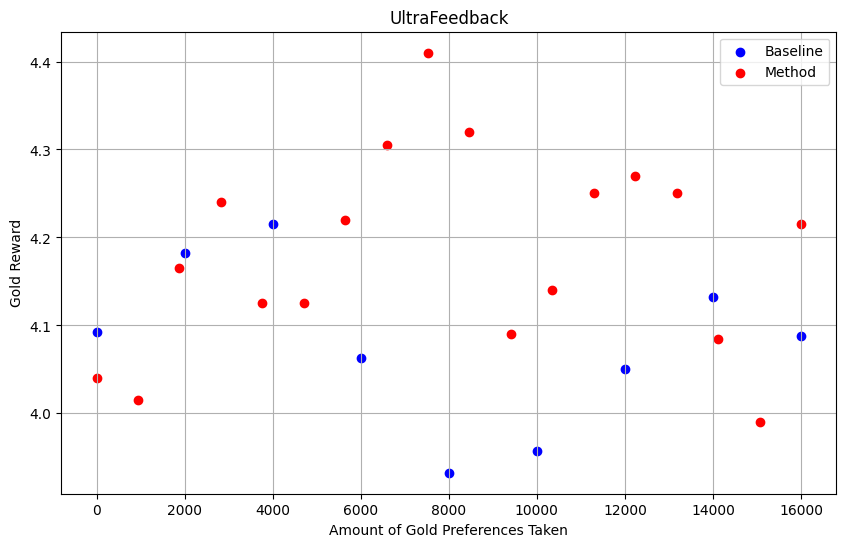

In [171]:
fig = ratio_scatter(basemeans, methmeans, 2000, baseratio, mratios[dset], "efficientplots/"+dset+".pdf", "UltraFeedback")

In [36]:
ngs, accs = makengs(tmp)

0.049515625


In [40]:
meanngs = list([mean(n) for n in ngs])

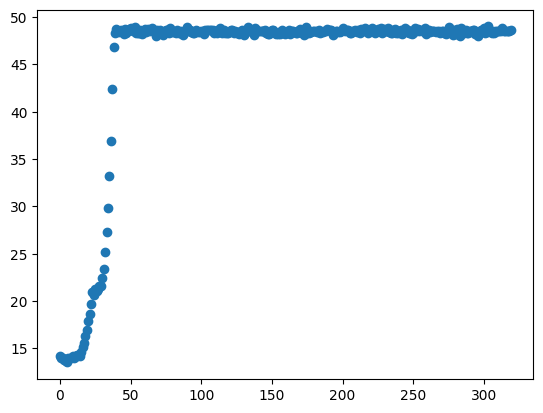

In [42]:
accscatter(meanngs)

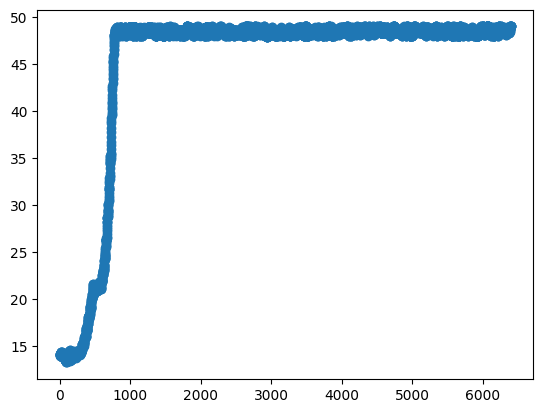

In [15]:
means = [mean(m) for m in ngs]
# means = [mean(m) for m in tmp['rewards']]

interv = 10
mbins = [mean(means[i:i+100]) for i in range(0, len(means), interv)]
plt.scatter(range(len(mbins)), mbins)

In [55]:
print(max(mbins))
print(mean(mbins[-100:]))

49.0
48.5851


In [194]:
tmp.iloc[1000:1010]

,texts,rewards,golds,call
1000,[Question: (((8 * 6) * 2) + 9) = \n\nAnswer: ...,"[-0.23632812500000003, -0.33984375]","[2.619047619047619, 2.611111111111111]","[63, 63]"
1001,[Question: (((2 * 9) * 4) - 2) = \n\nAnswer: ...,"[-0.2353515625, -0.2412109375]","[3.174603174603174, 3.611111111111111]","[63, 63]"
1002,[Question: (((7 * 8) - 4) - 8) = \n\nAnswer: ...,"[-0.208984375, -0.2314453125]","[2.444444444444444, 2.0]","[63, 63]"
1003,[Question: (((4 * 9) - (2 - 7)) - 2) = \n\nAns...,"[0.125, 0.12304687500000001]","[2.70021645021645, 1.7568779904306222]","[63, 63]"
1004,[Question: (((3 * 5) - 1) + 8) = \n\nAnswer: ...,"[-0.2470703125, -0.27734375]","[3.055555555555556, 2.166666666666667]","[63, 63]"
1005,[Question: (((9 * 3) * 5) + (4 * 3)) = \n\nAns...,"[-0.255859375, -0.259765625]","[3.178436147186147, 2.76176948051948]","[63, 63]"
1006,[Question: (((8 * 2) * 2) - 7) = \n\nAnswer: r...,"[-0.039306640625, -0.279296875]","[2.111111111111111, 2.444444444444444]","[63, 63]"
1007,[Question: (((1 * 4) * 1) * 4) = \n\nAnswer: ...,"[-0.1142578125, -0.2734375]","[4.166666666666667, 3.092592592592593]","[63, 63]"
1008,[Question: (((1 * 3) + 6) - 2) = \n\nAnswer: ...,"[-0.373046875, -0.251953125]","[2.777777777777777, 5.0]","[64, 64]"
1009,[Question: (((4 - 2) - 9) + (2 + 9)) = \n\nAns...,"[0.0137939453125, -0.23828125]","[2.285714285714286, 2.957417582417582]","[64, 64]"


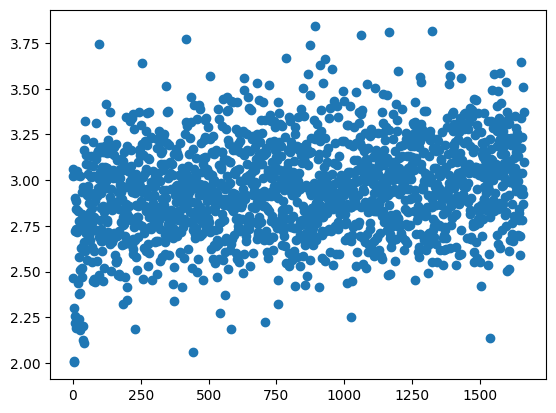

In [50]:
means = [mean(m) for m in tmp['golds']]
plt.scatter(range(len(means)), means)